# TP5 : Mesure de l’absorption de la lumière par des liquides
### Auteur : ARGUELLO Camilo

### Introduction

Dans ce TP, notre objectif c'est de mesurer le coefficient d'absorption molaire $\epsilon$ d'un liquide. Pour cela, nous allons utiliser un montage expérimental avec l'application [PhyPhox](https://phyphox.org/) qui nous permettra de mesurer l'intensité lumineuse. Ensuite, nous allons analyser les données obtenues pour déterminer le coefficient d'absorption du liquide.

#### Loi de Beer-Lambert

La loi de Beer-Lambert est une loi qui décrit l'absorption de la lumière par un milieu. Elle est donnée par l'équation suivante:

$$I = I_0 \; e^{-\epsilon \ l \ C}$$

Où $I_0$ est l'intensité lumineuse incidente, $I$ est l'intensité lumineuse transmise, $\epsilon$ est le coefficient d'absorption molaire, $l$ est l'épaisseur du milieu, et $C$ est la concentration du milieu.

À l'aide de cette relation, nous allons estimer **le coefficient d'absortion molaire $\epsilon$**, à partir de données expérimentales mesurés avec le capteur de luminosité de notre smartphone, en fonction de longueurs connues de liquide traversées par la lumière. 

#### Détermination de la position du capteur de luminosité


Pour réaliser cette expérience, nous utiliserons l'application Phyphox sur notre smartphone avec sa fonction de mesure de luminosité. En accédant à l'onglet 'Composantes' de l'application, nous positionnerons le capteur sous la source lumineuse. Ce dernier nous fournira alors une mesure de luminosité exprimée en lux.

Afin de vérifier le bon étalonnage du capteur, on place notre doigt sous le capteur, et on vérifie que l'intensité lumineuse mesurée est égale à 0. $l_x = 0$.

**Remarque**: Qu'est c'est passe si lorsqu'on place notre doigt sur le capteur, il ne marque pas 0?

> Dans ce cas on doit faire prendre cette valeur comme une incertitude sur la mesure de luminosité.


### Montage et protocole expérimental

Le montage expérimental est composé d'une source de lumière (lampe), d'un liquide (soda), et d'un capteur qui mesure l'intensité lumineuse (téléphone). La source de lumière est une LED blanche qui émet de la lumière dans le visible. Le liquide est contenu dans un bécher. Ainsi qu'un mètre pour mesurer les hauteurs du liquide Le montage est illustré dans la figure ci-dessous.

![Mesure Illustration](./images/mesure-illustration/mesure-illustration1.jpg)

1. L'expériment doit se faire dans un endroît sombre, pour éviter que la lumière ambiante interfère avec les mesures.
   
2. On place le bécher sur le capteur (téléphone), et en-dessous de la source de lumière. Eux, ils doivent être alignés, pour que la lumière passe à travers le liquide et arrive au capteur.

3. On demarre la collecte des données de luminosité avec l'application Phyphox. Ensuite, on mesure différentes longueurs de liquide dans le bécher, en prenant soin de ne pas déplacer le bécher ni renverser de liquide sur le smartphone. On va s'aider de la fonctionnalité de contrôle à distance.

4. On répéte les mesures pour différentes longueurs de liquide, toujours en prenant les mêmes précautions.

D’après le protocole expérimental, on mesure la hauteur de la solution liquide à l’aide d’un mètre.

On estime donc l’erreur sur la lecture de la hauteur à $\Delta h \approx  \pm 0.1 \ cm$.

Pour estimer une erreur sur la luminosité, on place un objet sombre devant la lampe pour bloquer la lumière, puis on le déplace. Cette opération est répétée plusieurs fois, en tenant compte notamment de la position du bécher au-dessus du téléphone. On constate que lorsque l'on place un objet sombre devant la lampe, l'intensité lumineuse diminue.

Le niveau d’erreur sur la luminosité que nous retiendrons par la suite est de $\Delta l \approx \pm 6.50 \ Lx$.

![Niveux de liquide avec des erreurs](./images/mesure-illustration/glass-levels.jpg)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import qexpy
from qexpy import MeasurementArray
import qexpy.plotting as qplt
from scipy.stats import linregress
from scipy.optimize import minimize

In [2]:
def calculate_uncertainty (hs):
    """
    Cette fonction calcule l'incertitude sur la moyenne d'une série de mesures
    """
    avg = np.mean(hs)
    std = np.std(hs) 
    dx = std / np.sqrt(len(hs))
    dh = np.sqrt(dx**2 + dx**2)
    return avg, dh

In [93]:
def load_data(folder_path, color='blue'):
    """
    Cette fonction charge les données des fichiers csv dans un dictionnaire
    @param folder_path: chemin du dossier contenant les données
    @param color: couleur de liquide (on a testé avec 3 couleurs différents bleu, rouge, jaune) des données à charger 
    """
    Color={}
    for folder_name in os.listdir(folder_path):
        folder_path_full = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder_path_full):
            raw_data_path = os.path.join(folder_path_full, 'Raw Data.csv')
            if os.path.isfile(raw_data_path):
                var_name = extract_yellow_number(folder_name, color)
                Color[var_name] = pd.read_csv(raw_data_path)
    return Color

def extract_yellow_number(folder_name, color='yellow'):
    """
    Cette fonction extrait le nom de color avec son numéro pour nommer la colonne
    @param folder_name: nom du dossier
    @param color: couleur à extraire
    """
    substrings = folder_name.split(color)
    if len(substrings) > 1:
        color_number = substrings[1]
        return f'{color}{color_number}'
    else:
        return None

On réalise une série de **6 mesures** correspondant à **6 hauteurs** de liquide différentes. On va stocker les données dans un `dict` sous la forme suivante:

```python
data = {
    'blue10': [['Temps (s)'] ... , ['Illuminance (lx)'] ...], # mesures pour la hauteur de 1 cm
    'blue20': [...], # mesures pour la hauteur de 2 cm
    'blue30': [...], # mesures pour la hauteur de 3 cm
    'blue40': [...], # mesures pour la hauteur de 4 cm
    'blue50': [...], # mesures pour la hauteur de 5 cm
    'blue60': [...]  # mesures pour la hauteur de 6 cm
}
```

In [138]:
folder_path = './data/Blue/'
Data = load_data(folder_path, color='blue')

heights = np.array([1.05, 2.03, 3.08, 4.03, 5.07, 6.05]) # Hauteur des liquides mésurés en cm
height_uncertainty = [0.1] * len(heights) # Incertitude sur la hauteur des liquides
luminosites = [Data[key]['Illuminance (lx)'].mean() for key in sorted(Data.keys())]
luminosite_uncertainties = [5] * len(luminosites) # Incertitude sur la luminosité

Vu que l'application Phyphox nous donne un tableau au cours du temps pour chaque mesure, et qu'on a bien vérifié que nos mésures son bien estables, alors on prendra la moyenne des valeurs pour chaque hauteur.

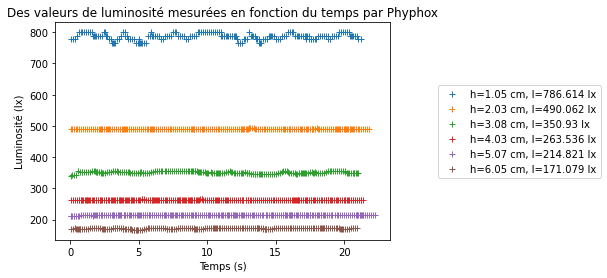

In [140]:
fig, ax = plt.subplots()

for i, height in enumerate(list(sorted(Data.keys())), start=0):
    ax.plot(Data[height]['Time (s)'], Data[height]['Illuminance (lx)'], '+', 
            label=f'h={heights[i]} cm, l={np.round(luminosites[i], 3)} lx')
    
plt.title('Des valeurs de luminosité mesurées en fonction du temps par Phyphox')
plt.xlabel('Temps (s)')
plt.ylabel('Luminosité (lx)')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

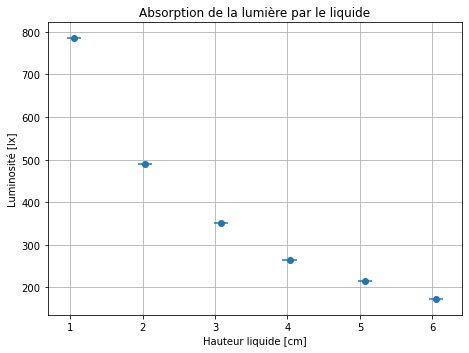

In [141]:
xs = MeasurementArray(heights, height_uncertainty, unit='cm', name='Hauteur liquide ')
ys = MeasurementArray(luminosites, luminosite_uncertainties, unit='lx', name='Luminosité ')

qplt.plot(xs, ys)
figure = qplt.get_plot()
figure.title = 'Absorption de la lumière par le liquide'
qplt.show()